[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/time-series/time-series-weather-small-embeddings.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/analytics-and-ml/time-series/time-series-weather-small-embeddings.ipynb)

# Predicting weather in the next hour using raw data

This notebook demonstrates how we can use vector search for time series forecasting on climate data with Pinecone.
We use the [Jena Climate dataset](https://www.kaggle.com/stytch16/jena-climate-2009-2016) for this example. Jena Climate dataset is made up of quantities such as air temperature, atmospheric pressure, humidity, wind direction, etc. that were recorded every 10 minutes, over several years. 

In a tabular dataset like this, every column can be seen as a feature vector identified uniquely by the time stamp associated with them. We can use these vectors to perform similarity search with a given query vector at a certain time to predict the weather for that hour. Though a very simple embedding extraction process, we want to see how far we can get even with a basic similarity search method like this. We will see how to do with Pinecone in the steps below.



### Install Pinecone




In [ ]:
!pip install pinecone-client matplotlib==3.2.2 tensorflow==2.9.2 scikit-learn==1.0.2 pandas==1.3.5 tqdm

In [28]:
import pinecone
import os

You can get your Pinecone API Key [here](https://www.pinecone.io/start/) if you don't have one.

In [29]:
# Load Pinecone API key
api_key = os.getenv('PINECONE_API_KEY') or 'YOUR_API_KEY'
# Set Pinecone environment. You can find your environment in the Pinecone console (https://app.pinecone.io) under Indexes.
env = os.getenv('PINECONE_ENVIRONMENT') or 'YOUR_ENVIRONMENT'
pinecone.init(api_key=api_key, environment=env)

#List all present indexes associated with your key, should be empty on the first run
pinecone.list_indexes()

[]


### Import other dependencies

In [30]:
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List
import itertools

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

### Load the dataset

In [31]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Load the hourly data into a dataframe

In [32]:
original_data_for_insert = pd.read_csv(csv_path)
original_data_for_insert = original_data_for_insert[5::6]

original_data_for_insert['Date Time'] = pd.to_datetime(original_data_for_insert['Date Time'], format='%d.%m.%Y %H:%M:%S')

Split data into data that is going to be inserted into Pinecone, and data that is going to be used for querying. 

In [33]:
n = len(original_data_for_insert)
train_data = original_data_for_insert[:int(n*0.9)]
test_data = original_data_for_insert[int(n*0.9):]


Let's see what the data looks like.

In [34]:
train_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Prepare data for upload. We will be querying data by the date and time.

In [35]:
items_to_upload = []
for row in train_data.values.tolist():
    key = str(row[0])
    values = row[1:]
    items_to_upload.append((key, values))

Prepare data that is going to be queried. 
Here we create two lists - one with dates that are going to be queried and the other one with vectors.



In [36]:
query_dates = []
query_data = []
for row in test_data.values.tolist():
    query_dates.append(str(row[0]))
    query_data.append(row[1:])

### Setting up an index

In [37]:
# Pick a name for the new service
index_name = 'time-series-weather'

In [38]:
# Check whether the index with the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [39]:
pinecone.create_index(name=index_name, dimension=14)

In [40]:
index = pinecone.Index(index_name=index_name)
index.describe_index_stats()

{'dimension': 14, 'namespaces': {}}

In [41]:
# Upload items
def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

for batch in chunks(items_to_upload, 500):
    index.upsert(vectors=batch)

In [42]:
# Check the index size to confirm the data was upserted properly
index.describe_index_stats()

{'dimension': 14, 'namespaces': {'': {'vector_count': 63081}}}

In [43]:
from tqdm.auto import tqdm

# Query items
all_query_results = []
for xq in tqdm(query_data):
    res = index.query(xq, top_k=1)
    all_query_results.append(res)

Here we create a function for getting predictions from Pinecone. We do this by using vectors to find the most similar vector in the index and then reading the hour after that.

In [44]:
def get_predictions(feature: str) -> (List, List):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, all_query_results):
        similar_date = [res.id for res in qr.matches][0]
        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1) 
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values


In [45]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {mean_squared_error(true_values, predicted_values, squared=False)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

### Results

To evaluate our results we will plot the predicted and true values for all the 14 features. 

Analyzing predictions for p (mbar)


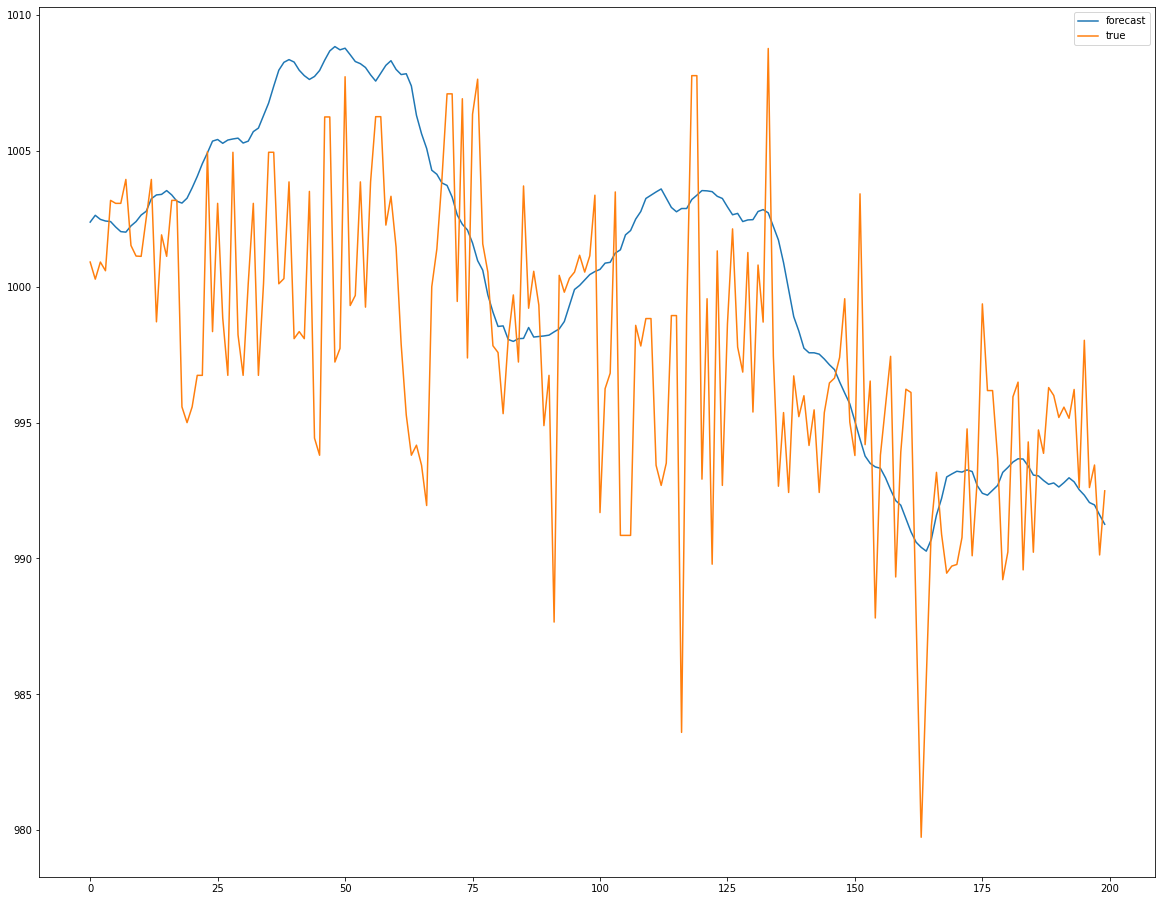

MSE: 22.21757760810618
RMSE: 4.713552546445852
MAE: 3.6907278435849866
Analyzing predictions for T (degC)


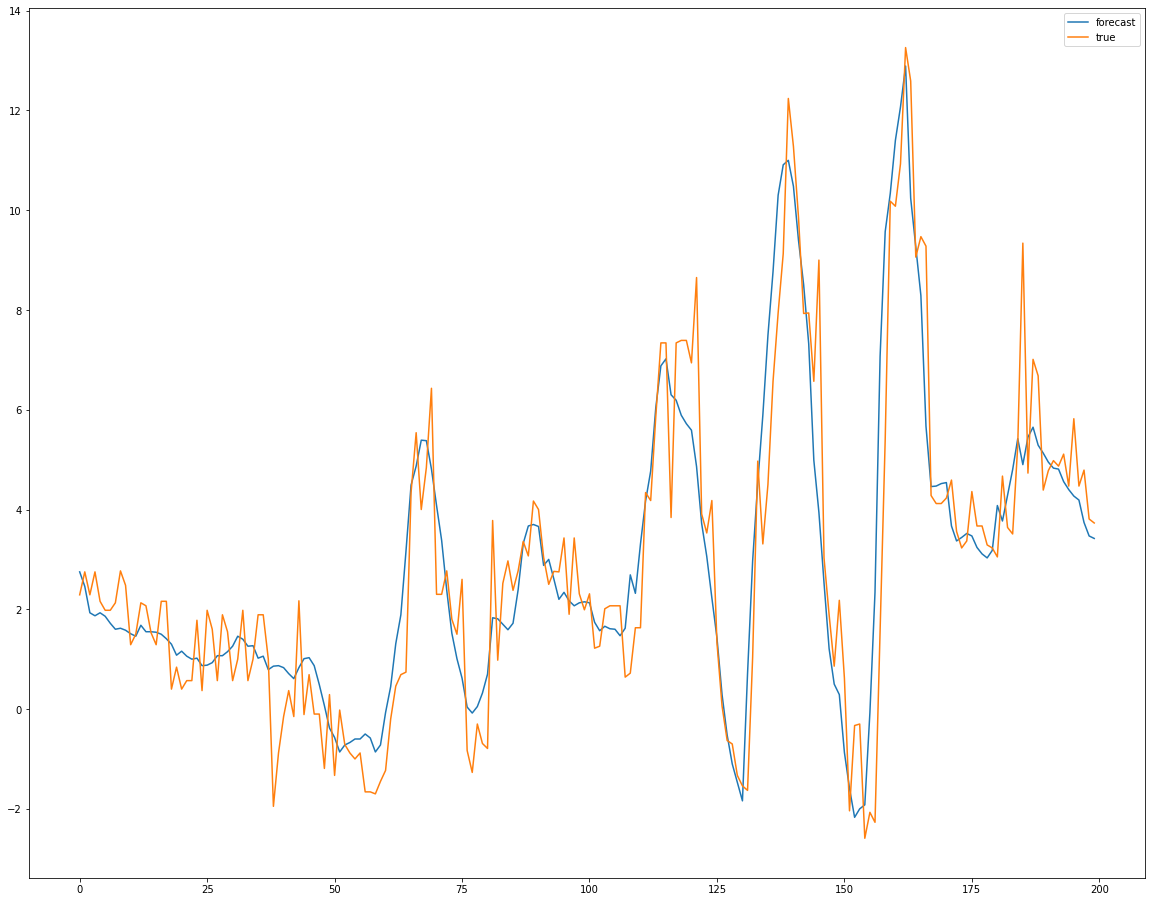

MSE: 2.121431511345797
RMSE: 1.4565134779142268
MAE: 1.0807563864706722
Analyzing predictions for Tpot (K)


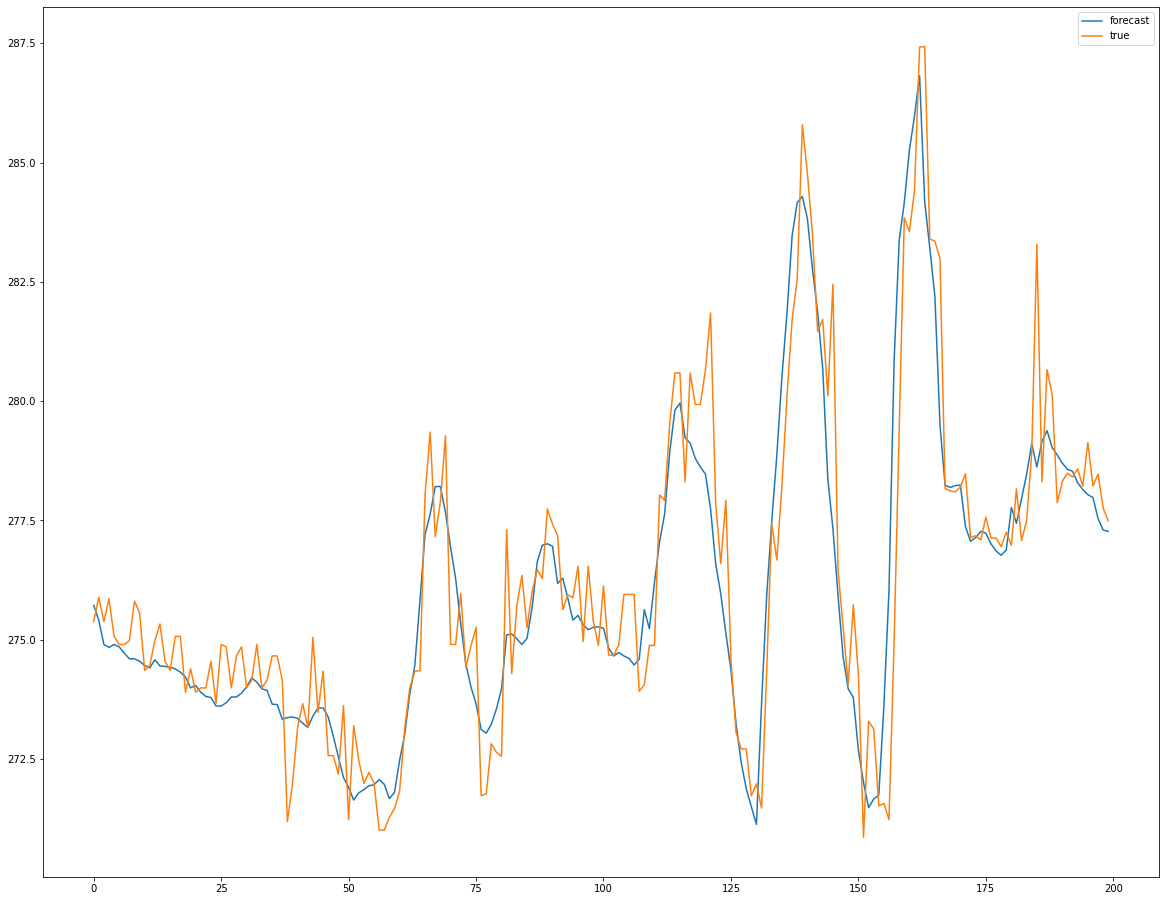

MSE: 2.1251254317111457
RMSE: 1.4577809957984587
MAE: 1.0802954188668474
Analyzing predictions for Tdew (degC)


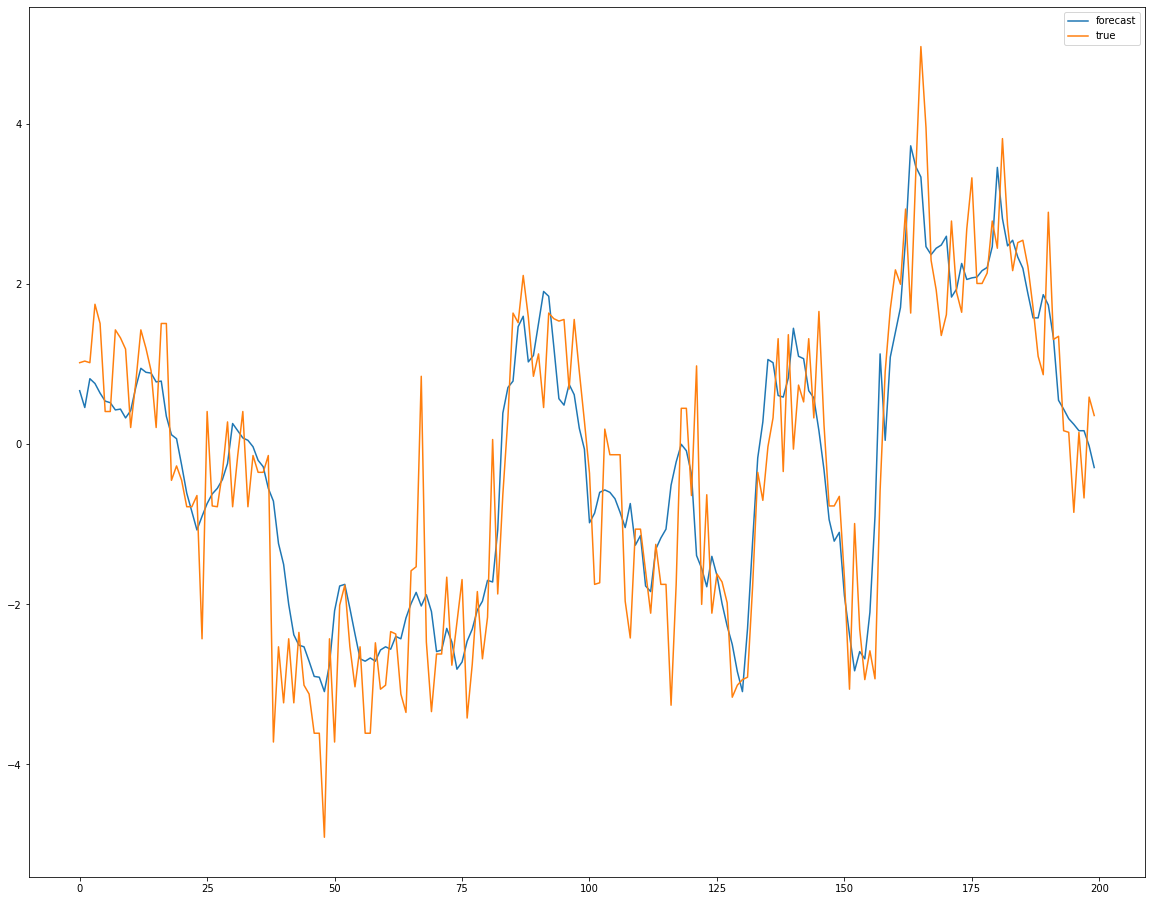

MSE: 0.9411405737120023
RMSE: 0.9701239991423789
MAE: 0.726636220921935
Analyzing predictions for rh (%)


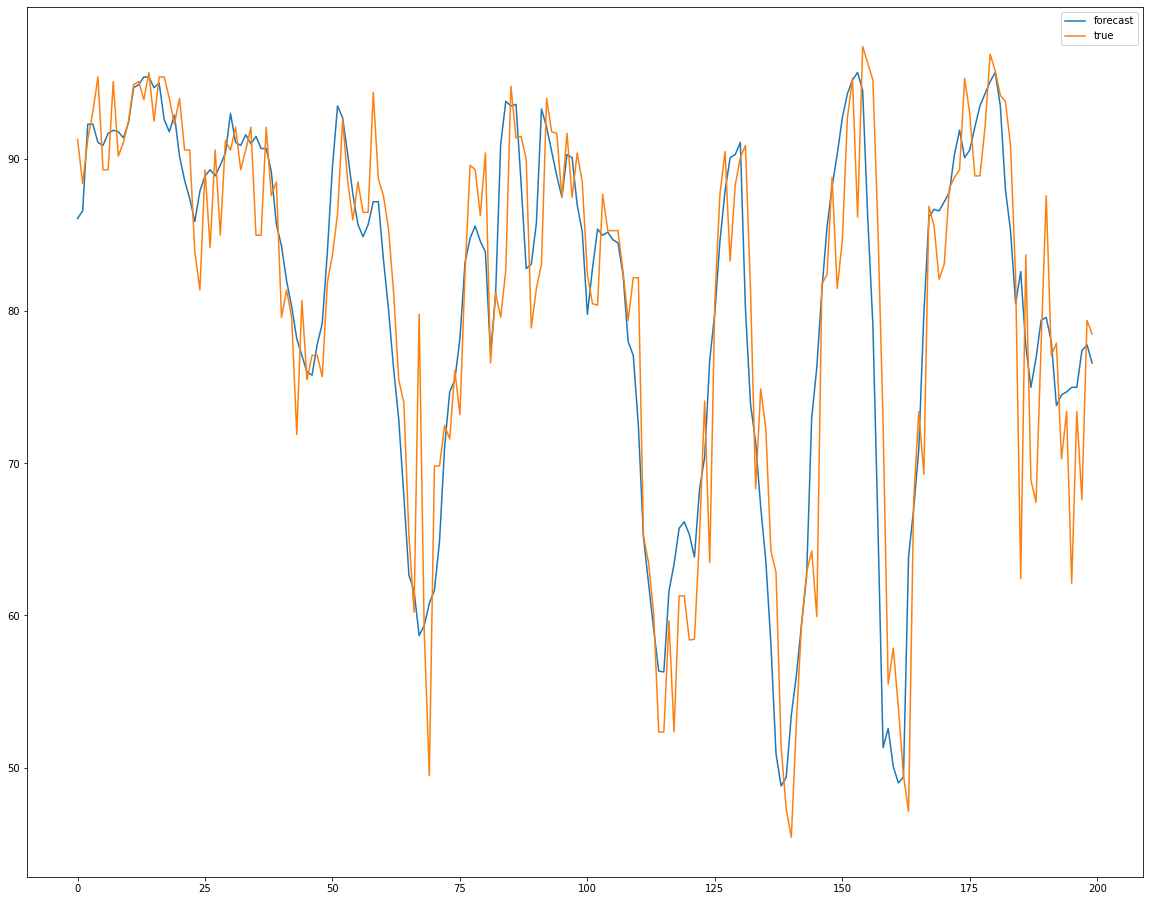

MSE: 41.016580048522904
RMSE: 6.40441879084456
MAE: 4.604903667760811
Analyzing predictions for VPmax (mbar)


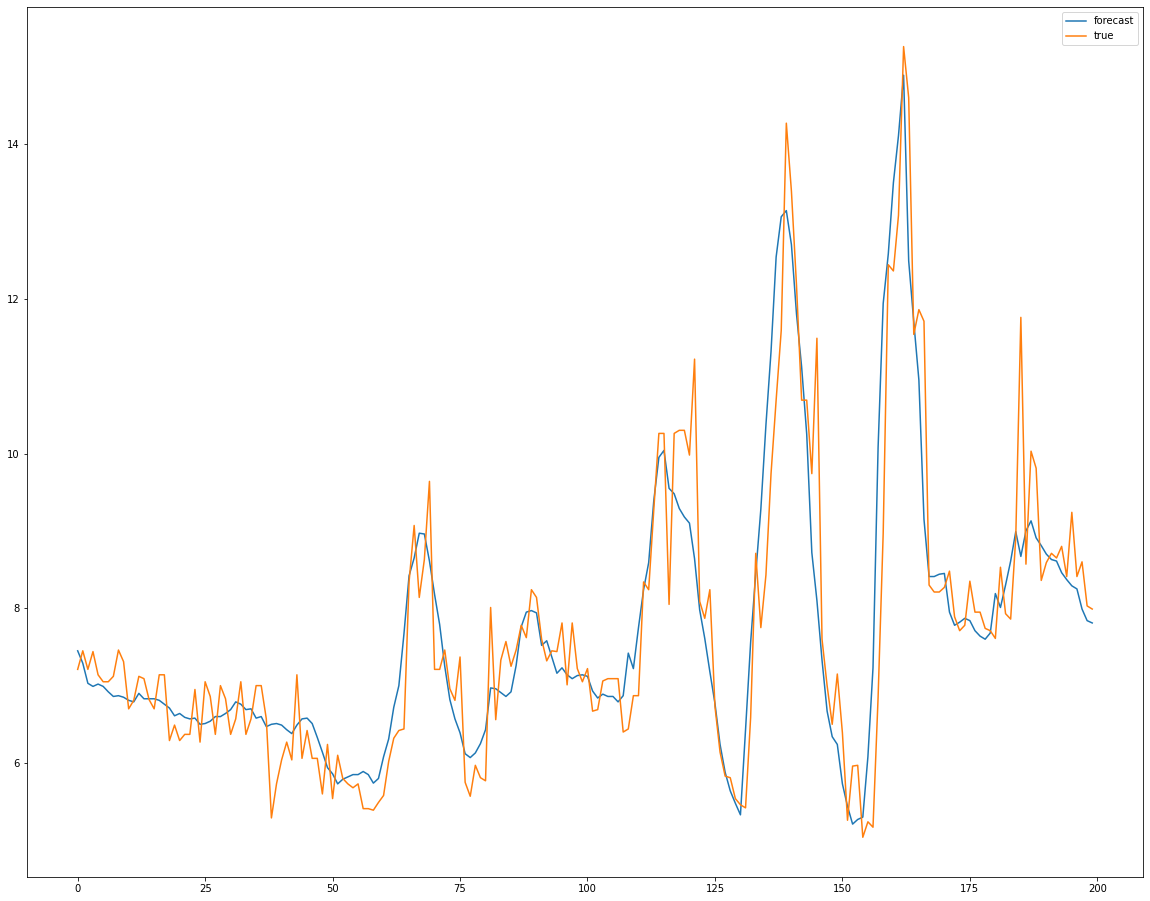

MSE: 3.064757157128586
RMSE: 1.7506447832523266
MAE: 1.1523790495219066
Analyzing predictions for VPact (mbar)


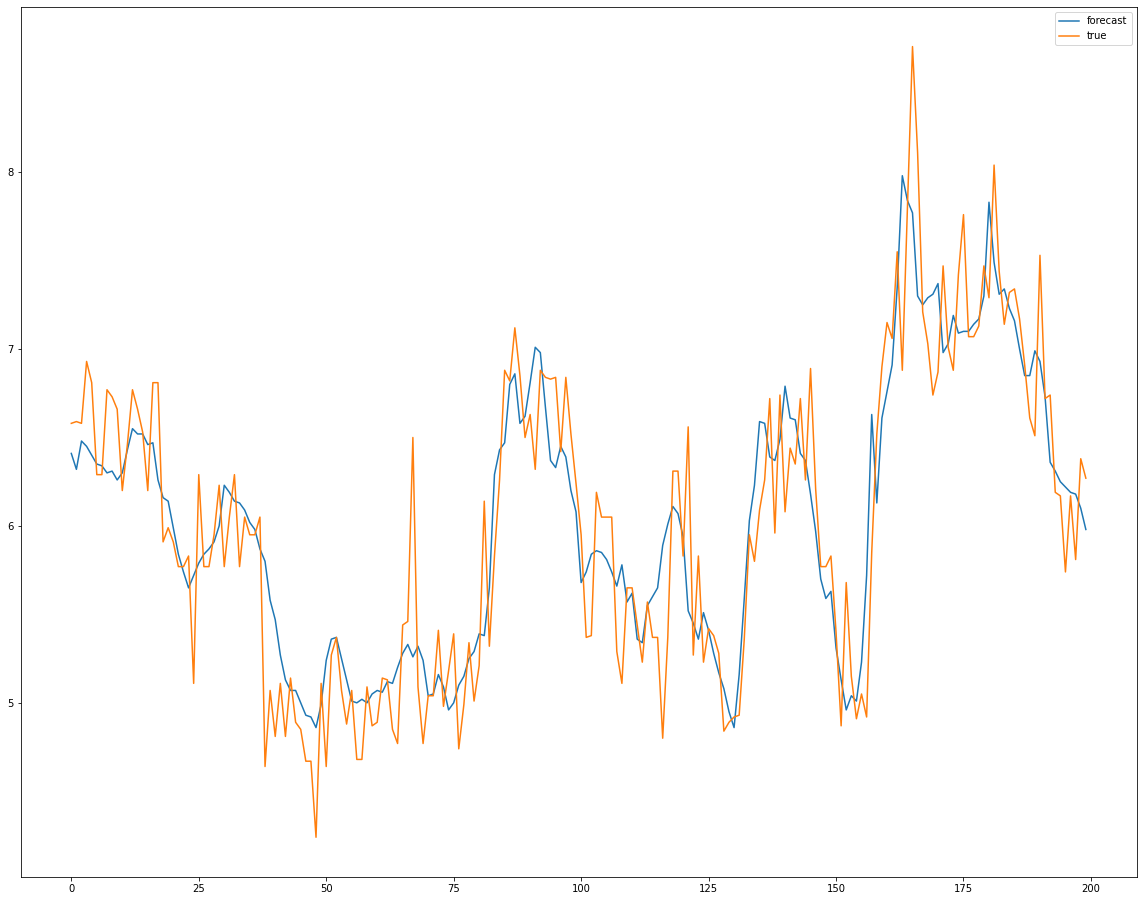

MSE: 0.5708024689596118
RMSE: 0.7555147046614062
MAE: 0.5295062080776366
Analyzing predictions for VPdef (mbar)


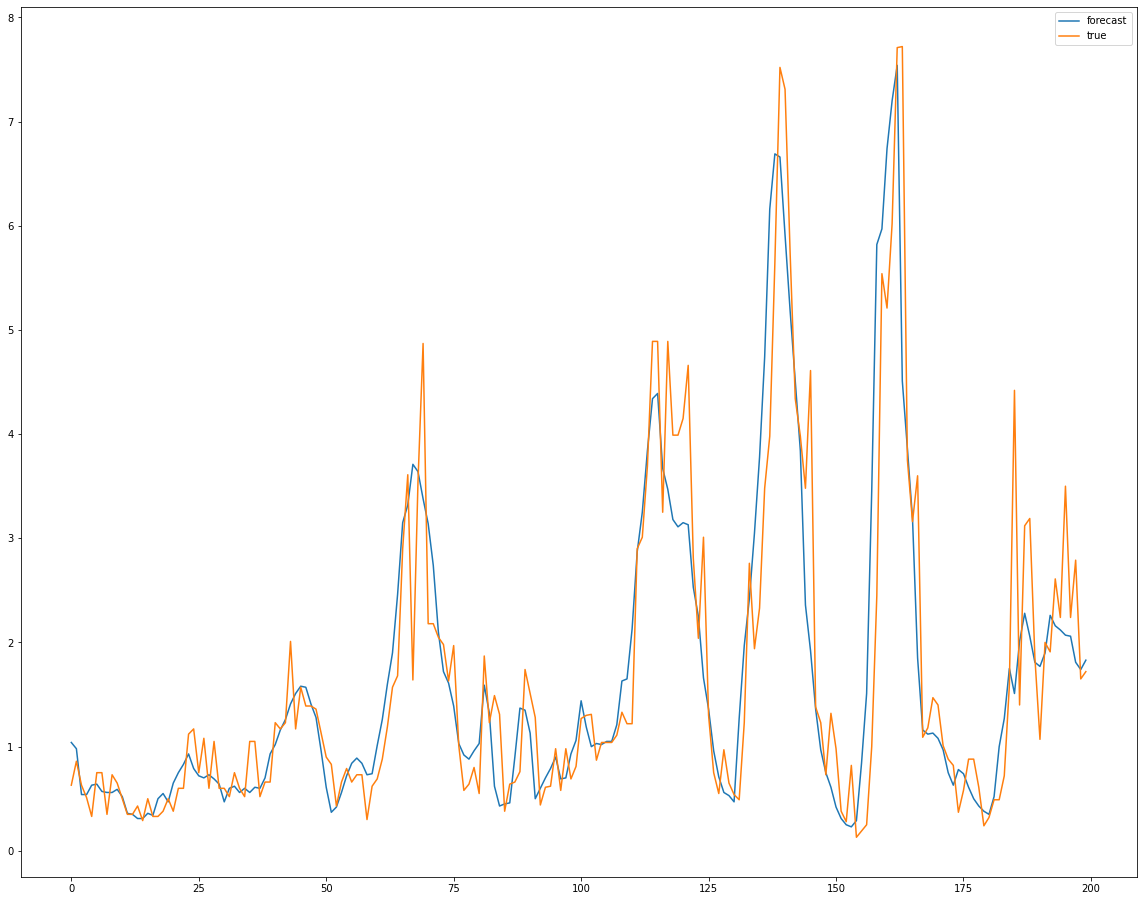

MSE: 3.1000084058798345
RMSE: 1.7606840732737474
MAE: 1.088236049664621
Analyzing predictions for sh (g/kg)


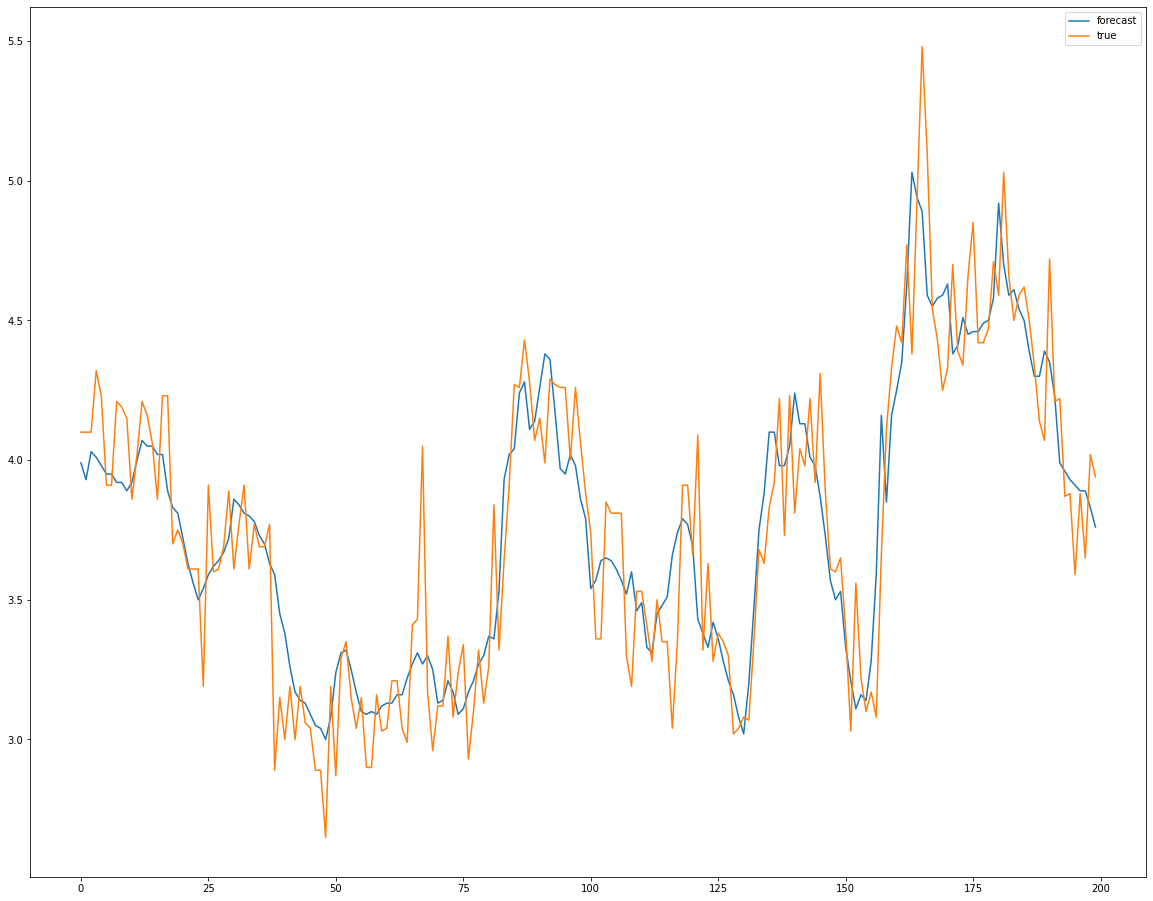

MSE: 0.22541298701298704
RMSE: 0.4747767759831846
MAE: 0.33115170543741973
Analyzing predictions for H2OC (mmol/mol)


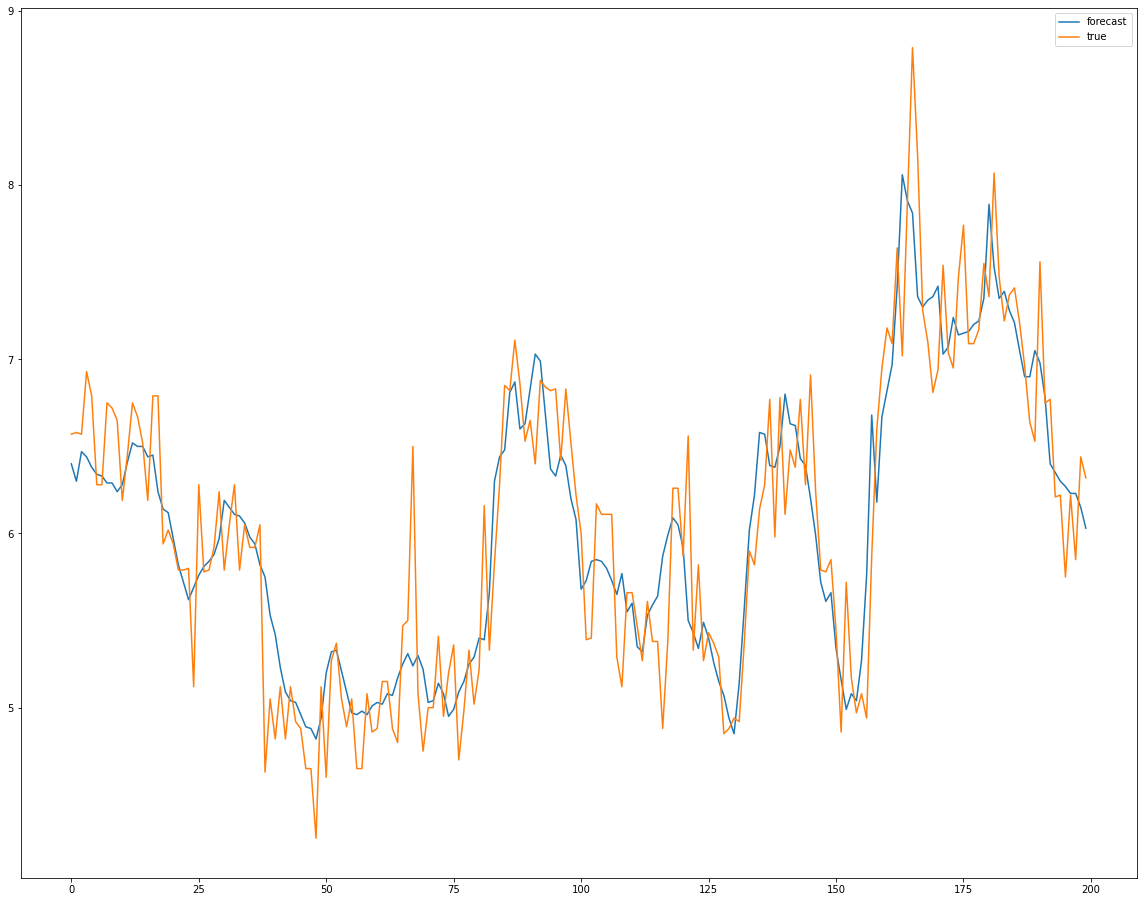

MSE: 0.5706698016269445
RMSE: 0.7554269002537204
MAE: 0.5275567289853005
Analyzing predictions for rho (g/m**3)


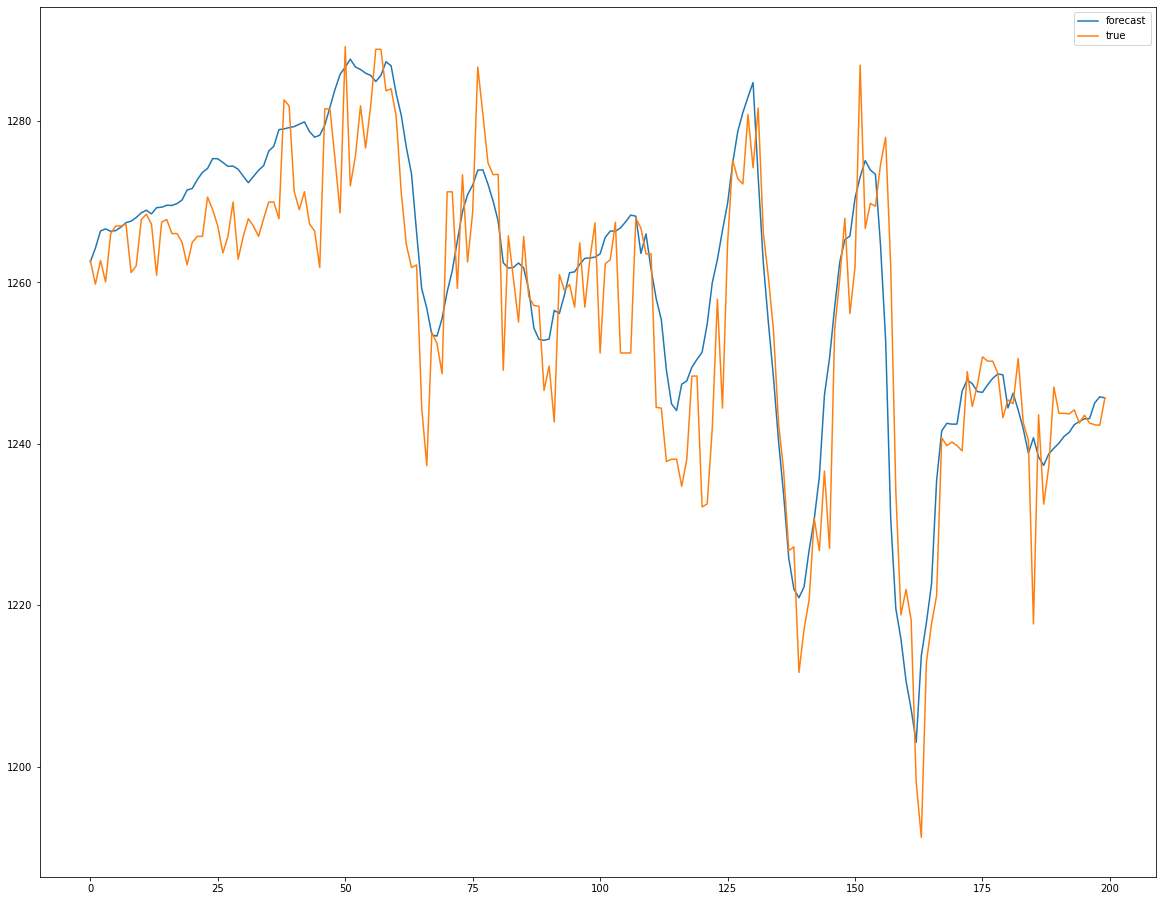

MSE: 61.30006126730413
RMSE: 7.829435565052192
MAE: 6.071355787070074
Analyzing predictions for wv (m/s)


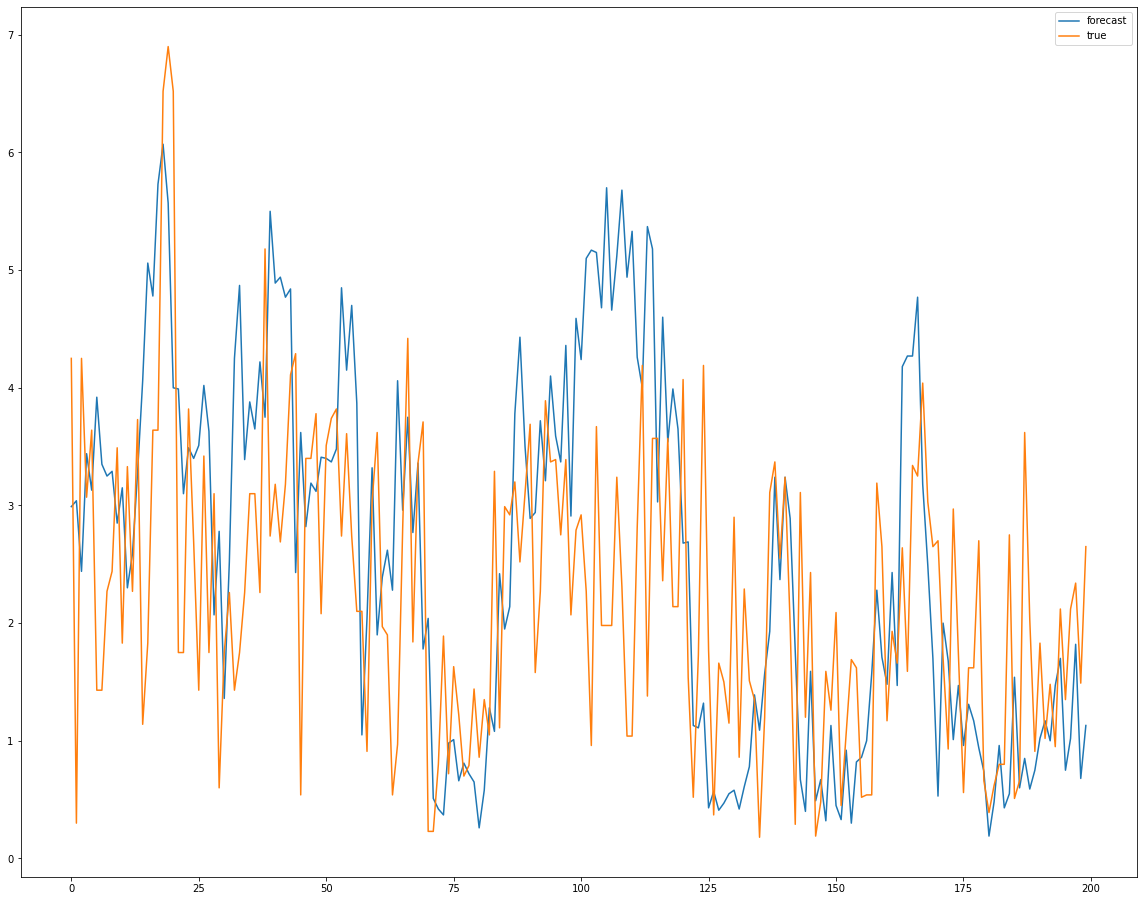

MSE: 1.7017898387326962
RMSE: 1.3045266722963913
MAE: 0.965497359783074
Analyzing predictions for max. wv (m/s)


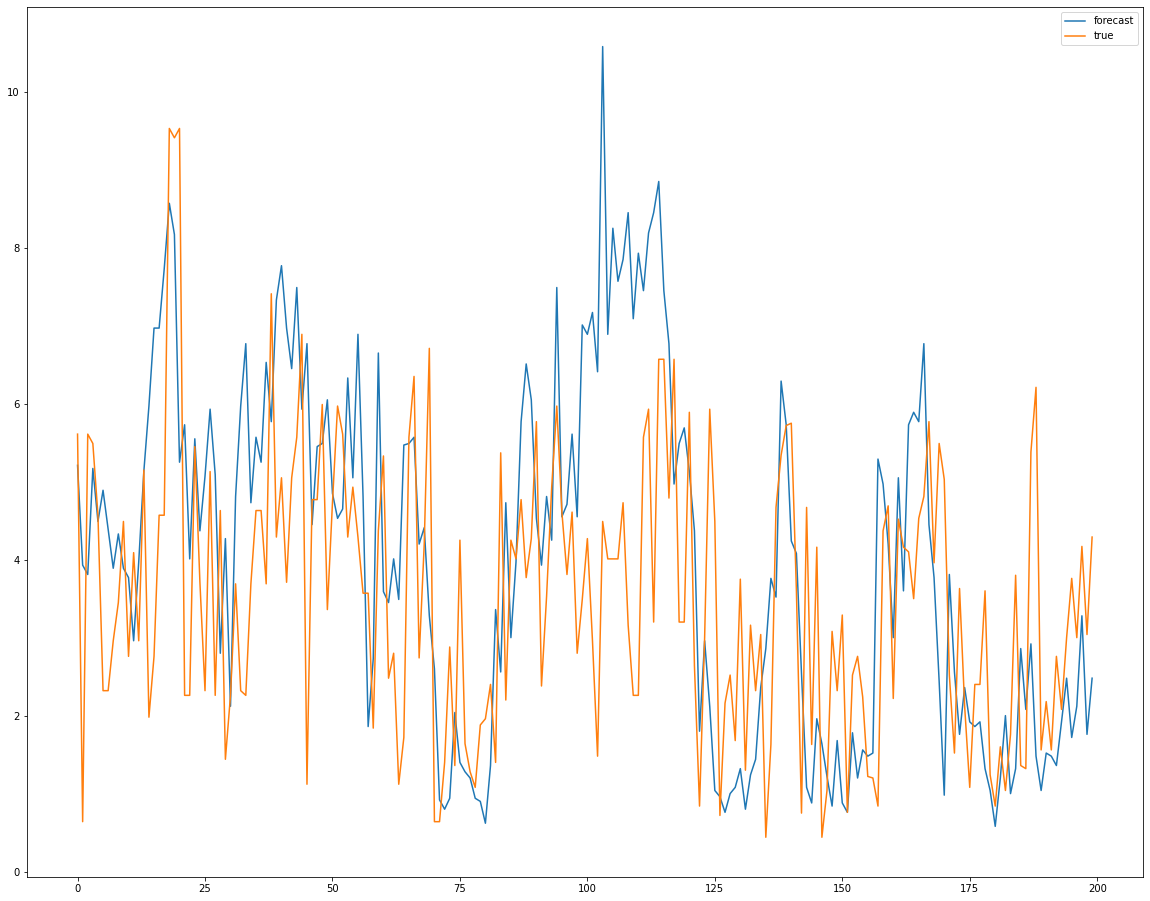

MSE: 3.9902911802483234
RMSE: 1.9975713204409808
MAE: 1.4846853146853147
Analyzing predictions for wd (deg)


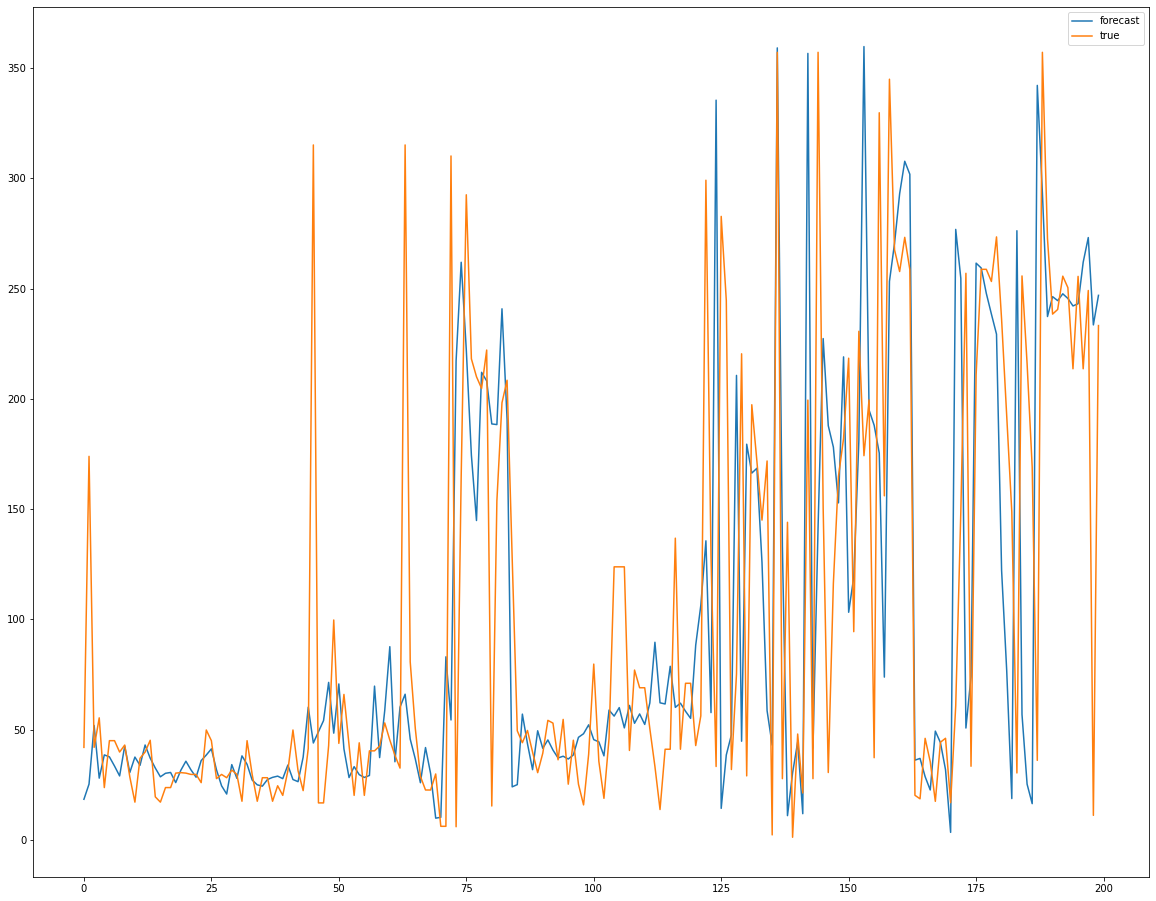

MSE: 9488.080172242044
RMSE: 97.40677682914081
MAE: 62.97315969744541


In [47]:
for feature in original_data_for_insert.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)
    print_results(true_values, predicted_values)

### Summary

From the plots above we can see that the method is able to predict pretty accurately for feature like VPdef, VPmax, rh(%) etc. predict roughly accurately for features like H20C, rho and is not that great for features like wd, max.vv, wv. Given how simple the approach is and doesn't involve any feature engineering, it does pretty good in some spots! 

We can improve these predictions by using more complex methods like LSTMs which are better suited to handle data like these.

### Delete the Index

Once we don't have use of the index we can delete them.


*Note: Index deletion is permanent*

In [48]:
pinecone.delete_index(index_name)